In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/CV/chess_yolo.zip
!unzip -qo "chess_yolo.zip"

--2024-11-28 17:53:00--  https://storage.yandexcloud.net/academy.ai/CV/chess_yolo.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39275734 (37M) [application/x-zip-compressed]
Saving to: ‘chess_yolo.zip’

chess_yolo.zip      100%[===================>]  37.46M  11.6MB/s    in 3.7s    

2024-11-28 17:53:05 (10.0 MB/s) - ‘chess_yolo.zip’ saved [39275734/39275734]



In [ ]:
# Обработка изображений
import cv2
from PIL import Image

# Линейная алгебра
import numpy as np

# Графики
from matplotlib import pyplot as plt


# Работаем с фреймворком Keras и Tensorflow
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU
from tensorflow.keras.layers import MaxPool2D, UpSampling2D, ZeroPadding2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.losses import sparse_categorical_crossentropy

from itertools import repeat

In [ ]:
import pandas as pd
from os import listdir
from os.path import isfile, join

# Базовые пути
train_images_path = "./chess_yolo/train/images"
train_labels_path = "./chess_yolo/train/labels"

valid_images_path = "./chess_yolo/valid/images"
valid_labels_path = "./chess_yolo/valid/labels"

test_images_path = "./chess_yolo/test/images"
test_labels_path = "./chess_yolo/test/labels"

# Собираю выборки
train_images = [f for f in sorted(listdir(train_images_path)) if isfile(join(train_images_path, f))]
train_labels = [f for f in sorted(listdir(train_labels_path)) if isfile(join(train_labels_path, f))]

valid_images = [f for f in sorted(listdir(valid_images_path)) if isfile(join(valid_images_path, f))]
valid_labels = [f for f in sorted(listdir(valid_labels_path)) if isfile(join(valid_labels_path, f))]

test_images = [f for f in sorted(listdir(test_images_path)) if isfile(join(test_images_path, f))]
test_labels = [f for f in sorted(listdir(test_labels_path)) if isfile(join(test_labels_path, f))]

# Классы изображений
# class_names = [ "слон", "черный слон", "черный король", "черный конь",
#                "черная пешка", "черный ферзь", "черная ладья", "белый слон",
#                 "белый король", "белый конь", "белая пешка", "белый ферзь",
#                 "белая ладья"]
# Английский язык, так как русский выводится вопросами
class_names = ["bishop", "black bishop", "black king", "black knight",
               "black pawn", "black queen", "black rook", "white bishop",
                "white king", "white knight", "white pawn", "white queen",
                "white rook"]

NUM_CLASSES = len(class_names) # число классов, на которых обучена модель

In [ ]:
# Немного информации
print(f"Тренировочная выборка по изображениям: {len(train_images)}")
print(f"Тренировочная выборка по меткам: {len(train_labels)}")

print(f"Валидационная выборка по изображениям: {len(valid_images)}")
print(f"Валидационная выборка по меткам: {len(valid_labels)}")

print(f"Тестовая выборка по изображениям: {len(test_images)}")
print(f"Тестовая выборка по меткам: {len(test_labels)}")

Тренировочная выборка по изображениям: 606
Тренировочная выборка по меткам: 606
Валидационная выборка по изображениям: 58
Валидационная выборка по меткам: 58
Тестовая выборка по изображениям: 29
Тестовая выборка по меткам: 29


In [ ]:
def create_DataFrame(labels, label_path, YOLO_MAX_BOXES):

  img_info = []
  # Бегаем по информациям
  for id, txt in enumerate(labels):
    # Открываем файл
    with open(join(label_path, txt), 'r') as file:
      txt = file.readlines()

      # Вычисляем максимальное количество изображений на картинке
      if YOLO_MAX_BOXES < len(txt):
        YOLO_MAX_BOXES = len(txt)

      # В тексте бывает много боксов, бегаем по ним
      for i in txt:
        # Из текста в лист
        label_info = i.split()

        # Получаем максимальные и минимальные значения + путь
        label_info = float(label_info[1]), float(label_info[2]), float(label_info[5]), float(label_info[6]), int(label_info[0]), join(train_images_path, train_images[id])

        img_info.append(label_info)

  return pd.DataFrame(img_info, columns=['x_min', 'y_min', 'x_max', 'y_max', 'category', 'img_path']), YOLO_MAX_BOXES

In [ ]:
YOLO_MAX_BOXES = 0
train_df, YOLO_MAX_BOXES = create_DataFrame(train_labels, train_labels_path, YOLO_MAX_BOXES)
print(f"train_df.shape:{train_df.shape}")
print(f'Максимальное количество боксов: {YOLO_MAX_BOXES}')

valid_df, YOLO_MAX_BOXES = create_DataFrame(valid_labels, valid_labels_path, YOLO_MAX_BOXES)
print(f"valid_df.shape:{valid_df.shape}")
print(f'Максимальное количество боксов: {YOLO_MAX_BOXES}')

test_df, YOLO_MAX_BOXES = create_DataFrame(test_labels, test_labels_path, YOLO_MAX_BOXES)
print(f"test_df.shape: {test_df.shape}")
print(f'Максимальное количество боксов: {YOLO_MAX_BOXES}')

train_df.shape:(6324, 6)
Максимальное количество боксов: 32
valid_df.shape:(386, 6)
Максимальное количество боксов: 32
test_df.shape: (376, 6)
Максимальное количество боксов: 32


In [ ]:
def DBL(x, filters, kernel, strides=1, batch_norm=True):
    if strides == 1:
        padding = 'same'
    else:
        # Делаем oтступ в виде нулей по контуру изображения, что бы захватить левый верхний угол
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)
        padding = 'valid'
    x = Conv2D(filters=filters, kernel_size=kernel,
              strides=strides, padding=padding,
              use_bias=not batch_norm,  # используем смещение, если нет нормализации
              kernel_regularizer=l2(0.0005))(x)
    if batch_norm:
        x = BatchNormalization(epsilon=0.001)(x)
        x = LeakyReLU(negative_slope=0.1)(x)
    return x



In [ ]:
def ResUnit(x, filters):
    skip_connection  = x
    x = DBL(x, filters // 2, 1)
    x = DBL(x, filters, 3)
    x = Add()([skip_connection , x])
    return x

In [ ]:
def ResN(x, filters, blocks):
    x = DBL(x, filters, kernel=3, strides=2)
    for _ in repeat(None, blocks): # цикл по n-блокам (подход с repeat позволяет экономить память)
        x = ResUnit(x, filters)
    return x

In [ ]:
def Darknet(name=None):
    x = inputs = Input([None, None, 3])
    x = DBL(x, 32, 3)
    x = ResN(x, 64, 1)
    x = ResN(x, 128, 2)
    x = Route_1 = ResN(x, 256, 8)
    x = Route_2 = ResN(x, 512, 8)
    Route_3 = ResN(x, 1024, 4)
    return tf.keras.Model(inputs, (Route_1, Route_2, Route_3), name=name)

In [ ]:
def YoloHead(filters, name=None):
    def layer(x_in):
        if isinstance(x_in, tuple): #
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            x = DBL(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])

        x = DBL(x, filters, 1)
        x = DBL(x, filters * 2, 3)
        x = DBL(x, filters, 1)
        x = DBL(x, filters * 2, 3)
        x = DBL(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return layer

def YoloHeadOutput(filters, anchors, classes, name=None):
    def layer(x_in):

        x = inputs = Input(x_in.shape[1:])
        x = DBL(x, filters * 2, 3)
        x = DBL(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                        anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return layer

In [ ]:
yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                        (59, 119), (116, 90), (156, 198), (373, 326)], np.float32) / 416
yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

In [ ]:
def yolo_boxes(pred, anchors, classes):
    # На входе pred размера (S, S, 3, (1+4+80))

    grid_size = tf.shape(pred)[1] # S ячеек в сетке

    # В box_xy и box_wh помещаем сразу по 2 переменные (tx, ty) и (tw, th)
    box_xy, box_wh, score, class_probs = tf.split(pred, (2, 2, 1, classes), axis=-1) # раскладываем предсказанную карту по переменным

    # Применяем сигмоидные функции
    box_xy = tf.sigmoid(box_xy)
    score = tf.sigmoid(score)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)


    # Построим сетку S x S
    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)

    # Привяжем box_xy к ячейкам сетки, учтем смещения (и снова нормируем к диапазону 0, 1)
    # Фактически мы вычисляем центральное положение рамки относительно размеров сетки (якорного поля)
    b_xy = (box_xy + tf.cast(grid, tf.float32)) /  tf.cast(grid_size, tf.float32) # вычисляем b_xy: (bx, by)

    b_wh = tf.exp(box_wh) * anchors # вычисляем b_wh: (bw, bh), ширина и высота рамки bbox

    box_x1y1 = b_xy - b_wh / 2
    box_x2y2 = b_xy + b_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1) # задаем рамку bbox, как 2 координаты углов


    return bbox, score, class_probs, pred_box

In [ ]:
def nonMaximumSuppression(outputs, anchors, masks, classes):
    boxes, conf, out_type = [], [], []

    # Блок преобразования трех выходов разных масштабов
    for output in outputs:
        boxes.append(tf.reshape(output[0], (tf.shape(output[0])[0], -1, tf.shape(output[0])[-1])))
        conf.append(tf.reshape(output[1], (tf.shape(output[1])[0], -1, tf.shape(output[1])[-1])))
        out_type.append(tf.reshape(output[2], (tf.shape(output[2])[0], -1, tf.shape(output[2])[-1])))

    # Конкатенируем три масштаба в один
    bbox = tf.concat(boxes, axis=1)
    confidence = tf.concat(conf, axis=1)
    class_probs = tf.concat(out_type, axis=1)

    scores = confidence * class_probs # Оценки считаем как произведение оценок объектности на вероятности классов

    # Применяем NMS из пакета tensorflow (работаем с документацией, смотрим параметры самостоятельно: https://www.tensorflow.org/api_docs/python/tf/image/combined_non_max_suppression)
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class=YOLO_MAX_BOXES,
        max_total_size=YOLO_MAX_BOXES,
        iou_threshold=YOLO_IOU_THRESHOLD,
        score_threshold=YOLO_SCORE_THRESHOLD)

    return boxes, scores, classes, valid_detections

In [ ]:
YOLO_IOU_THRESHOLD = 0.6 # порог для оценок перекрытия IOU в NMS (параметр iou_threshold в tf.image.combined_non_max_suppression)
YOLO_SCORE_THRESHOLD = 0.6 # порог для оценок scores применяется в NMS (параметр score_threshold в tf.image.combined_non_max_suppression)

SIZE = 416 # изменяем изображения до размеров

In [ ]:
def YoloV3(size=None, channels=3, anchors=yolo_anchors,
            masks=yolo_anchor_masks, classes=80, training=False):
    # Вход
    x = inputs = Input([size, size, channels])

    # Модель Darknet с тремя выходами
    Route_1, Route_2, Route_3 = Darknet(name='yolo_darknet')(x)

    # Определяем 3 головы с разным числом фильтров
    x = YoloHead(512, name='yolo_head_1')(Route_3)
    output_0 = YoloHeadOutput(512, len(masks[0]), classes, name='yolo_output_1')(x)

    x = YoloHead(256, name='yolo_head_2')((x, Route_2))
    output_1 = YoloHeadOutput(256, len(masks[1]), classes, name='yolo_output_2')(x)

    x = YoloHead(128, name='yolo_head_3')((x, Route_1))
    output_2 = YoloHeadOutput(128, len(masks[2]), classes, name='yolo_output_3')(x)

    if training: # заложим модель для обучения (понадобиться в домашней работе)
        return Model(inputs, (output_0, output_1, output_2), name='yolov3')

    # Перегоняем предсказанные якорные рамки в boundary box для трех выходов
    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                  name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                  name='yolo_boxes_1')(output_1)
    boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                  name='yolo_boxes_2')(output_2)

    # Отсекаем все лишнее алгоритмом NMS
    outputs = Lambda(lambda x: nonMaximumSuppression(x, anchors, masks, classes),
                  name='nonMaximumSuppression')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

    return Model(inputs, outputs, name='yolov3') # возвращаем модель для инференса

In [ ]:
def broadcast_iou(box_1, box_2):
    # box_1: (..., (x1, y1, x2, y2))
    # box_2: (N, (x1, y1, x2, y2))

    # broadcast boxes
    box_1 = tf.expand_dims(box_1, -2)
    box_2 = tf.expand_dims(box_2, 0)
    # new_shape: (..., N, (x1, y1, x2, y2))
    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_1), tf.shape(box_2))
    box_1 = tf.broadcast_to(box_1, new_shape) # it will change the shape of box into new_shape given
    box_2 = tf.broadcast_to(box_2, new_shape)

    # in below code we are finding intersection box width and height through which we will find intersection area.
    # and this we are finding all boxes
    int_w = tf.maximum(tf.minimum(box_1[..., 2], box_2[..., 2]) -
                       tf.maximum(box_1[..., 0], box_2[..., 0]), 0)
    int_h = tf.maximum(tf.minimum(box_1[..., 3], box_2[..., 3]) -
                       tf.maximum(box_1[..., 1], box_2[..., 1]), 0)
    int_area = int_w * int_h  # area of intersection
    box_1_area = (box_1[..., 2] - box_1[..., 0]) * \
        (box_1[..., 3] - box_1[..., 1]) # this box_1_area contains all boxes area predicted in an image
    box_2_area = (box_2[..., 2] - box_2[..., 0]) * \
        (box_2[..., 3] - box_2[..., 1]) # this box2_area is our ground truth box area

    # Formula: Union(A,B) = A + B - Inter(A,B)
    return int_area / (box_1_area + box_2_area - int_area)

In [ ]:
def YoloLoss(anchors, classes=80, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):

        # 1. Преобразуем все предсказанные выходы
        # y_pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...cls))
        # с функцией yolo_boxes мы уже знакомы
        pred_box, pred_obj, pred_class, pred_xywh = yolo_boxes(
            y_pred, anchors, classes)
        pred_xy = pred_xywh[..., 0:2]
        pred_wh = pred_xywh[..., 2:4]

        # 2. Преобразуем все реальные значения
        # y_true: (batch_size, grid, grid, anchors, (x1, y1, x2, y2, obj, cls))
        true_box, true_obj, true_class_idx = tf.split(
            y_true, (4, 1, 1), axis=-1)
        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
        true_wh = true_box[..., 2:4] - true_box[..., 0:2]

        # Чем меньше рамка, тем больше ошибка
        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]

        # 3. Инвертируем  уравнений красного прямоугольника inverting the pred box equations
        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_xy = true_xy * tf.cast(grid_size, tf.float32) - \
            tf.cast(grid, tf.float32)
        true_wh = tf.math.log(true_wh / anchors)
        true_wh = tf.where(tf.math.is_inf(true_wh),
                      tf.zeros_like(true_wh), true_wh)

        # 4. Вычисляем ignore_mask
        obj_mask = tf.squeeze(true_obj, -1)

        # ignore false positive when iou is over threshold
        best_iou = tf.map_fn(
            lambda x: tf.reduce_max(broadcast_iou(x[0], tf.boolean_mask(
                x[1], tf.cast(x[2], tf.bool))), axis=-1),
            (pred_box, true_box, obj_mask),
            tf.float32)
        ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)

        # 5. Вычисляем все функции ошибок
        xy_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
        wh_loss = obj_mask * box_loss_scale * \
            tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)

        obj_loss = binary_crossentropy(true_obj, pred_obj)
        obj_loss = obj_mask * obj_loss + \
            (1 - obj_mask) * ignore_mask * obj_loss

        # Можно использовать как binary_crossentropy, так и sparse_categorical_crossentropy
        class_loss = obj_mask * sparse_categorical_crossentropy(
            true_class_idx, pred_class)

        # 6. Все функции ошибок суммируются по осям для каждого пакета (batch, gridx, gridy, anchors) => (batch, 1)
        xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
        class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))

        # Общая суммарная ошибка
        return xy_loss + wh_loss + obj_loss + class_loss
    return yolo_loss

In [ ]:
@tf.function
def transform_targets_for_output(y_true, grid_size, anchor_idxs, classes):

    N = tf.shape(y_true)[0]

    y_true_out = tf.zeros(
      (N, grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))

    anchor_idxs = tf.cast(anchor_idxs, tf.int32)

    indexes = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
    idx = 0
    for i in tf.range(N):
        for j in tf.range(tf.shape(y_true)[1]):
            if tf.equal(y_true[i][j][2], 0):
                continue
            anchor_eq = tf.equal(
                anchor_idxs, tf.cast(y_true[i][j][5], tf.int32))

            if tf.reduce_any(anchor_eq):
                box = y_true[i][j][0:4]
                box_xy = (y_true[i][j][0:2] + y_true[i][j][2:4]) / 2

                anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)
                grid_xy = tf.cast(box_xy // (1/grid_size), tf.int32)

                indexes = indexes.write(
                    idx, [i, grid_xy[1], grid_xy[0], anchor_idx[0][0]])
                updates = updates.write(
                    idx, [box[0], box[1], box[2], box[3], 1, y_true[i][j][4]])
                idx += 1

    return tf.tensor_scatter_nd_update(
        y_true_out, indexes.stack(), updates.stack())


def transform_targets(y_train, anchors, anchor_masks, classes):
    outputs = []
    grid_size = 13

    # рассчитать индекс привязки для истинных блоков
    anchors = tf.cast(anchors, tf.float32) # якорные рамки в float
    anchor_area = anchors[..., 0] * anchors[..., 1] # расчет площади анкеров
    box_wh = y_train[..., 2:4] - y_train[..., 0:2] # здесь мы выполняем xmax-xmin, ymax-ymin, используя векторы
    box_wh = tf.tile(tf.expand_dims(box_wh, -2),
                    (1, 1, tf.shape(anchors)[0], 1))
    box_area = box_wh[..., 0] * box_wh[..., 1] # это наша зона Основного ящика истины
    intersection = tf.minimum(box_wh[..., 0], anchors[..., 0]) * \
        tf.minimum(box_wh[..., 1], anchors[..., 1]) # здесь мы пытаемся получить область долговых расписок
    iou = intersection / (box_area + anchor_area - intersection) # простая операция пересечения/объединения
    anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32) # сохранение тех индексов привязки, которые имеют наибольший номер долговой расписки
    anchor_idx = tf.expand_dims(anchor_idx, axis=-1)

    y_train = tf.concat([y_train, anchor_idx], axis=-1)

    for anchor_idxs in anchor_masks:
        outputs.append(transform_targets_for_output(
            y_train, grid_size, anchor_idxs, classes))
        grid_size *= 2 # здесь мы вызываем вышеуказанную функцию для сетки 13*13, затем сетки 26*26, затем сетки 52*52

    return tuple(outputs) # [x, y, w, h, obj, class]


def preprocess_image(x_train, size):
    return (tf.image.resize(x_train, (size, size))) / 255

In [ ]:
def draw_outputs(img, outputs, class_names, white_list=None):
    boxes, score, classes, nums = outputs # распознанные объекты
    boxes, score, classes, nums = boxes[0], score[0], classes[0], nums[0]

    wh = np.flip(img.shape[0:2]) # предсказанные ширина и высота
    print(wh)
    print(f"nums: {nums}")

    for i in range(nums):
        # Отображаем объекты только из white_list
        if class_names[int(classes[i])] not in white_list:
            continue

        # Предсказанные координаты нижнего левого и правого верхнего углов
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))

        # Рисуем прямоугольник по двум предсказанным координатам
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 1)

        # Выводим имя класса предсказанного объекта и оценку
        img = cv2.putText(img, '{} {:.2f}'.format(
            class_names[int(classes[i])], score[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 0), 1)
    return img

In [ ]:
def detect_objects(img_path, white_list=None):
    image = img_path # путь к файлу
    img = tf.image.decode_image(open(image, 'rb').read(), channels=3) # загружаем изображение как тензор

    img = tf.expand_dims(img, 0) # добавляем размерность

    img = preprocess_image(img, SIZE) # ресайзим изображение
    boxes, scores, classes, nums = yolo(img) # делаем предсказание

    img = cv2.imread(image) # считываем изображение как картинку, чтобы на нем рисовать
    print(img.shape)
    # Отрисовываем на картинке предсказанные объекты
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names, white_list)

    # # Сохраняем изображения с предсказанными объектами
    # cv2.imwrite('detected_{:}'.format(img_path), img)

    # # Открываем сохраненные изображения и выводим на экран
    # detected = Image.open('detected_{:}'.format(img_path))
    # detected.show()
    plt.imshow(img)

In [ ]:
from tqdm import tqdm

def parse_dataset(data,size,image,path,yolo_max_boxes,count=0):
    X = []
    Y = []
    # iterating over all images in a train dataset
    for img in tqdm(image):
        x_train = Image.open(join(path,img)) # reading image
        width,height = x_train.size # storing actual width and height so that we can later scale it
        x_train = x_train.resize((size,size)) # resizing
        x_train = np.array(x_train)
        temp_data = []
        # ierating over dataset having info about objects in an image
        for _,row in data[data['img_path']==join(path,img)].iterrows():
            xmin = row.x_min
            xmax = row.x_max
            ymin = row.y_min
            ymax = row.y_max
            cls = row.category
            temp_data.append([xmin,ymin,xmax,ymax,cls])
        temp_data = temp_data+[[0,0,0,0,0]]*(yolo_max_boxes-len(temp_data)) # it's like padding
        Y.append(temp_data)
        X.append(x_train)
    return(np.array(X),np.stack(np.array(Y)))

In [ ]:
# Тренировочный датасет
x,y= parse_dataset(train_df,SIZE,train_images[:],train_images_path,YOLO_MAX_BOXES)
x = x.astype(np.float32)
y = y.astype(np.float32)
train_dataset = tf.data.Dataset.from_tensor_slices((x,y))

# Валидационный датасет
x,y= parse_dataset(valid_df,SIZE,valid_images[:],valid_images_path,YOLO_MAX_BOXES)
x = x.astype(np.float32)
y = y.astype(np.float32)
valid_dataset = tf.data.Dataset.from_tensor_slices((x,y))

100%|██████████| 58/58 [00:00<00:00, 455.17it/s]


In [ ]:
def prepare_dataset(dataset):
    # Перетасовываем
    dataset = dataset.shuffle(buffer_size=64)
    # Разбиваем на батчи
    dataset = dataset.batch(8)
    # Трансформируем в вид yolov3
    dataset = dataset.map(lambda x, y: (preprocess_image(x, SIZE),
                                    transform_targets(y, yolo_anchors, yolo_anchor_masks, SIZE)))
    # Настраиваем подготовку батчей
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

train_dataset = prepare_dataset(train_dataset)

valid_dataset = prepare_dataset(valid_dataset)

In [ ]:
yolo = YoloV3(SIZE, training=True, classes=NUM_CLASSES)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # Адам оптимизатор
loss = [YoloLoss(yolo_anchors[mask], classes=NUM_CLASSES) # YoloLoss
            for mask in yolo_anchor_masks]

In [ ]:
avg_train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32) # Потери для тренировочной выборки
avg_valid_loss = tf.keras.metrics.Mean('valid_loss', dtype=tf.float32) # Потери для валидационной выборки

epochs = 50
for epoch in range(epochs+1):
    # Обучение
    for batch, (images, labels) in enumerate(train_dataset):
        with tf.GradientTape() as tape:

            outputs = yolo(images, training=True)
            regularization_loss = tf.reduce_sum(yolo.losses)
            pred_loss = []
            for output, label, loss_fn in zip(outputs, labels, loss):
                pred_loss.append(loss_fn(label, output))
            total_loss = tf.reduce_sum(pred_loss) + regularization_loss

        grads = tape.gradient(total_loss, yolo.trainable_variables)
        optimizer.apply_gradients(zip(grads, yolo.trainable_variables))
        avg_train_loss.update_state(total_loss)


    # Проверка на валидационной выборке
    for batch, (images, labels) in enumerate(valid_dataset):
        outputs = yolo(images)
        regularization_loss = tf.reduce_sum(yolo.losses)
        pred_loss = []
        for output, label, loss_fn in zip(outputs, labels, loss):
            pred_loss.append(loss_fn(label, output))
        total_loss = tf.reduce_sum(pred_loss) + regularization_loss
        avg_valid_loss.update_state(total_loss)

    print("{} эпоха, train_loss: {}, valid_loss: {}".format(epoch,
                                                            avg_train_loss.result().numpy(),
                                                            avg_valid_loss.result().numpy()))
    avg_train_loss.reset_state()
    avg_valid_loss.reset_state()
yolo.save_weights('yolov3_chess.weights.h5')

0 эпоха, train_loss: 21571.0703125, valid_loss: 28414.6328125
1 эпоха, train_loss: 7467.63720703125, valid_loss: 12804.8681640625
2 эпоха, train_loss: 5520.75341796875, valid_loss: 7222.3623046875
3 эпоха, train_loss: 3967.527099609375, valid_loss: 3959.391357421875
4 эпоха, train_loss: 3005.763916015625, valid_loss: 2616.8916015625
5 эпоха, train_loss: 2418.88623046875, valid_loss: 1844.8575439453125
6 эпоха, train_loss: 2004.507568359375, valid_loss: 1523.8182373046875
7 эпоха, train_loss: 1866.24072265625, valid_loss: 1267.065185546875
8 эпоха, train_loss: 1497.1044921875, valid_loss: 1114.9268798828125
9 эпоха, train_loss: 1237.40185546875, valid_loss: 947.9199829101562
10 эпоха, train_loss: 1058.8641357421875, valid_loss: 836.4886474609375
11 эпоха, train_loss: 941.1818237304688, valid_loss: 771.704833984375
12 эпоха, train_loss: 836.6334838867188, valid_loss: 736.3670654296875
13 эпоха, train_loss: 734.2042236328125, valid_loss: 642.3021240234375
14 эпоха, train_loss: 664.3104248

In [ ]:
yolo = YoloV3(size=SIZE, classes=NUM_CLASSES, training=False)
yolo.load_weights('./yolov3_chess.weights.h5')

(416, 416, 3)
[416 416]
nums: 4


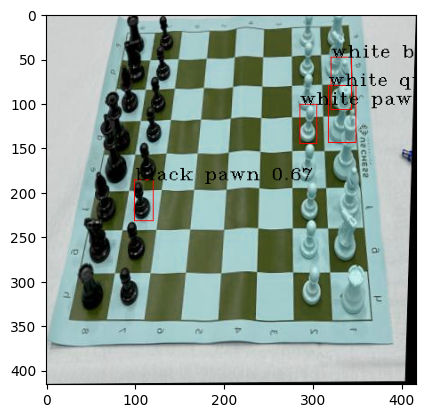

In [ ]:
detect_objects(train_df.iloc[60].img_path, class_names)

(416, 416, 3)
[416 416]
nums: 2


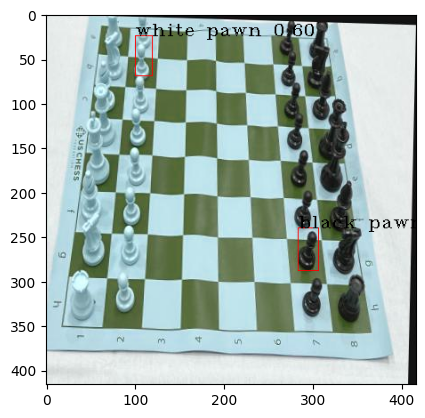

In [ ]:
detect_objects(train_df.iloc[15].img_path, class_names)

(416, 416, 3)
[416 416]
nums: 3


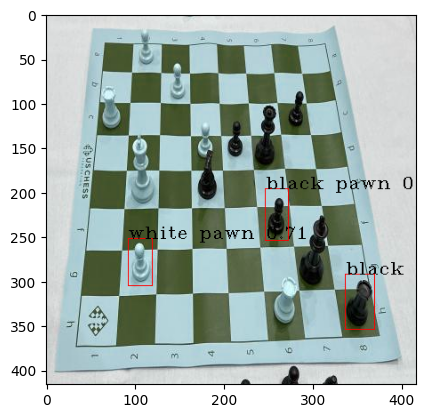

In [ ]:
detect_objects('./chess_yolo/test/e4583d082076b2b549b3736ad1b193c9_jpg.rf.c64d9d89f8d479bf811e6b355b93e90e.jpg', class_names)

(416, 416, 3)
[416 416]
nums: 3


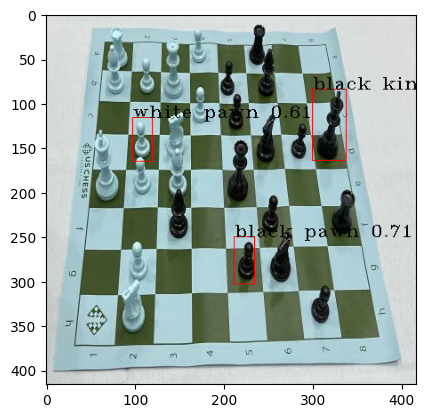

In [ ]:
detect_objects('./chess_yolo/test/fdcd6ada676799da8a870f58fdf548db_jpg.rf.b0ea8552b6106bb4ab62ca8957fca40d.jpg', class_names)

(416, 416, 3)
[416 416]
nums: 0


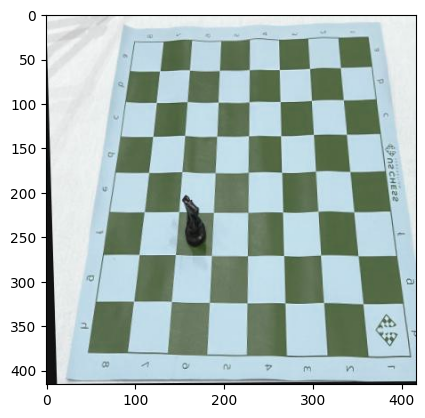

In [ ]:
detect_objects(test_df.iloc[-2].img_path, class_names)

(416, 416, 3)
[416 416]
nums: 4


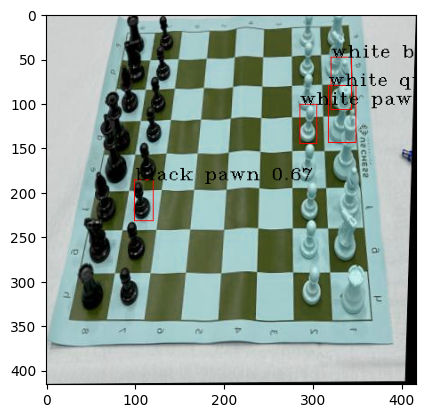

In [ ]:
detect_objects(train_df.iloc[55].img_path, class_names)